In [39]:
import numpy as np
import pandas as pd
from defillama2 import DefiLlama
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.2f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 4)
# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

### Download Data

Let's download wbtc and weth hourly price data from ethereum using DefiLlama's 
data api. After that, we'll calculate BTCETH hourly prices by dividing the two 
price series, i.e., `WBTC/WETH`.

In [2]:
dd = {'0x2260FAC5E5542a773Aa44fBCfeDf7C193bc2C599':'ethereum', # wbtc, ethereum
      '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2':'ethereum', # weth, ethereum
      }

# set download start and end dates
start_str = '2022-11-01'
end_str   = '2022-12-06'

In [3]:
llama = DefiLlama()
df = llama.get_tokens_hist_prices(dd, start_str, end_str, 'hourly')
print(df.head(), end='\n\n')
print(df.tail())

                         WBTC     WETH
datetime                              
2022-11-01 00:00:00 20,488.00 1,573.18
2022-11-01 01:00:00 20,450.00 1,568.53
2022-11-01 02:00:00 20,517.00 1,579.61
2022-11-01 03:00:00 20,607.00 1,597.75
2022-11-01 04:00:00 20,472.00 1,589.79

                         WBTC     WETH
datetime                              
2022-12-05 20:00:00 16,932.77 1,257.81
2022-12-05 21:00:00 16,874.68 1,254.29
2022-12-05 22:00:00 16,966.30 1,259.35
2022-12-05 23:00:00 16,964.83 1,259.44
2022-12-06 00:00:00 16,967.96 1,260.05


In [4]:
# calc BTCETH
df['BTCETH'] = df.WBTC / df.WETH
df.tail()

,WBTC,WETH,BTCETH
datetime,,,
2022-12-05 20:00:00,"16,932.77","1,257.81",13.46
2022-12-05 21:00:00,"16,874.68","1,254.29",13.45
2022-12-05 22:00:00,"16,966.30","1,259.35",13.47
2022-12-05 23:00:00,"16,964.83","1,259.44",13.47
2022-12-06 00:00:00,"16,967.96","1,260.05",13.47


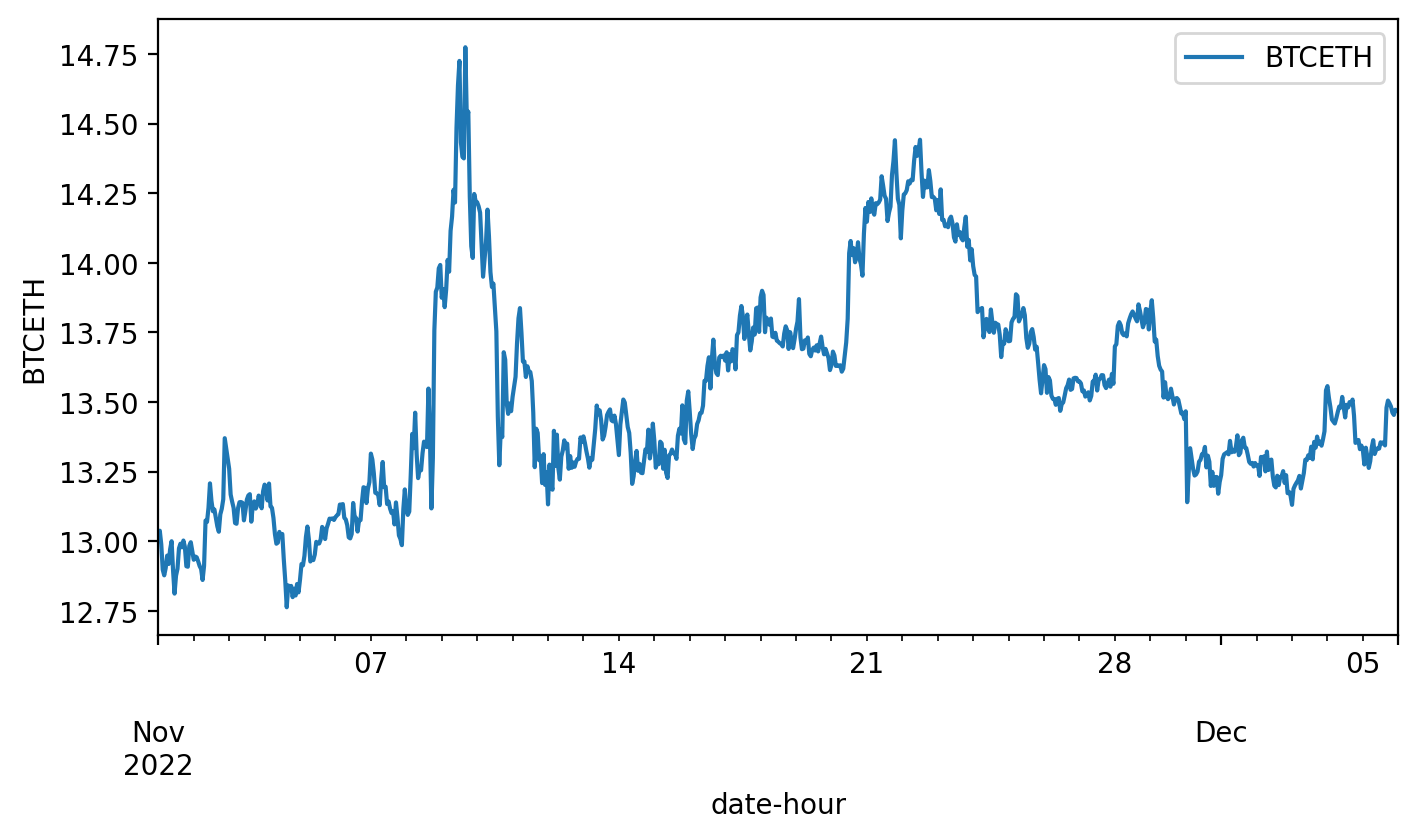

In [5]:
df.plot(y='BTCETH', fontsize=10)
plt.xlabel('date-hour', fontsize=10)
plt.ylabel('BTCETH', fontsize=10)
plt.show()

### Explore Data

In [6]:
# check missing
df.isna().sum()

WBTC      0
WETH      0
BTCETH    0
dtype: int64

In [7]:
# summary stats
df.describe()

,WBTC,WETH,BTCETH
count,841.00,841.00,841.00
mean,"17,573.00","1,303.93",13.51
std,"1,719.44",156.23,0.38
min,"15,604.64","1,085.42",12.76
25%,"16,480.65","1,206.66",13.25
50%,"16,823.48","1,256.84",13.46
75%,"17,687.61","1,301.39",13.75
max,"21,450.00","1,664.63",14.77


### Forecast next-hour BTCETH price using prior hourly prices with Autoregression

Summary of steps:

1. Split the `BTCETH` series into training and test sets.
2. Scale the data so that all values are in the range of 0 and 1.
3. Pick how many lags to use as features.
4. Train an autoregression on training set, and look at the model parameters estimates.
5. Train and forecast iteratively and calculate prediction error.

In [58]:
btceth = df.BTCETH.asfreq('H')

In [59]:
# 1. split into train and test sets
train_stop_time = '2022-12-03 23:00:00'
train = btceth[btceth.index <= train_stop_time].to_frame()
test  = btceth[btceth.index > train_stop_time].to_frame()
print('Training data size:', len(train))
print(train.tail(), end='\n\n')
print('Test data size:', len(test))
print(test.head())

Training data size: 792
                     BTCETH
datetime                   
2022-12-03 19:00:00   13.36
2022-12-03 20:00:00   13.34
2022-12-03 21:00:00   13.37
2022-12-03 22:00:00   13.39
2022-12-03 23:00:00   13.54

Test data size: 49
                     BTCETH
datetime                   
2022-12-04 00:00:00   13.56
2022-12-04 01:00:00   13.51
2022-12-04 02:00:00   13.48
2022-12-04 03:00:00   13.44
2022-12-04 04:00:00   13.43


In [60]:
# 2. scale data to (0, 1). Notice that we train a scaler() on training data first 
# and apply it to the test set to avoid data leaking.
scaler = MinMaxScaler()
train['BTCETH'] = scaler.fit_transform(train)

# scale test data to be in range(0, 1)
test['BTCETH'] = scaler.transform(test)

# print scaled data
print('Scaled training set:')
print(train.tail(), end='\n\n')
print('Scaled test set:')
print(test.head())

Scaled training set:
                     BTCETH
datetime                   
2022-12-03 19:00:00    0.30
2022-12-03 20:00:00    0.29
2022-12-03 21:00:00    0.30
2022-12-03 22:00:00    0.31
2022-12-03 23:00:00    0.39

Scaled test set:
                     BTCETH
datetime                   
2022-12-04 00:00:00    0.39
2022-12-04 01:00:00    0.37
2022-12-04 02:00:00    0.36
2022-12-04 03:00:00    0.34
2022-12-04 04:00:00    0.33


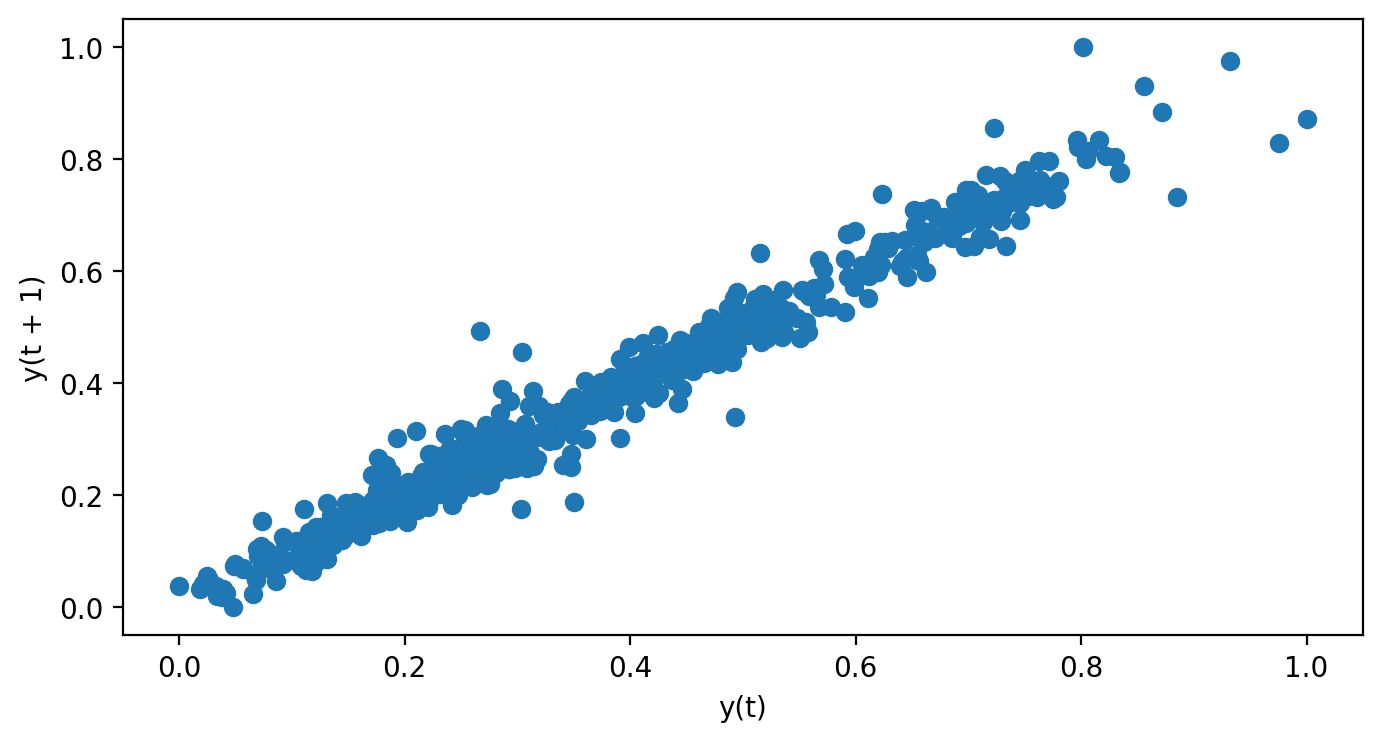

In [61]:
# 3. how many lags shall we use as predictors? 
#    lag1: price at last hour, t-1
#    lag2: price 2 hours ago, t-2
#    lag3: price 3 hours ago, t-3

# let's first plot a lag plot
pd.plotting.lag_plot(train, lag=1);

We see there is a strong linear relationship between lag1 (last hour price) and 
price (current hour price). So we definitely want to use lag1 as a predictor. 

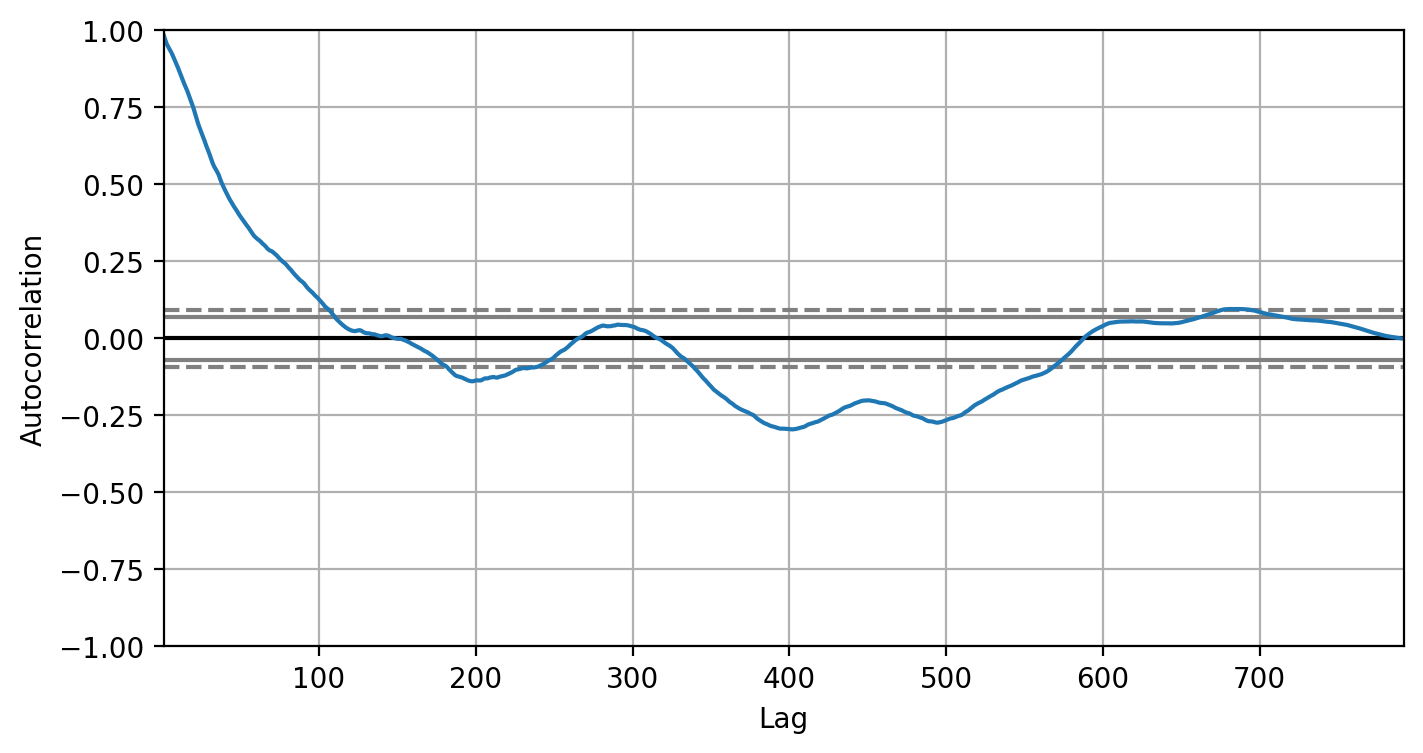

In [62]:
# let's make an autocorrelation plot next.
pd.plotting.autocorrelation_plot(train);

We see when the lag number is small, the correlation between the lag and current price is high. For example, at the extreme end when lag number is 1, the correlation between last hour price and current price is close to 1, confirming the strong linear pattern we saw in the lag plot above. As the lag number increases, autocorrelation decreases and sometimes gets close to zero after 100 lags. But between lag 300 and 600, autocorrelation becomes negative and becomes as large as -0.25. The dashed and solid gray horizontal lines are the 99% and 95% confidence intervals.

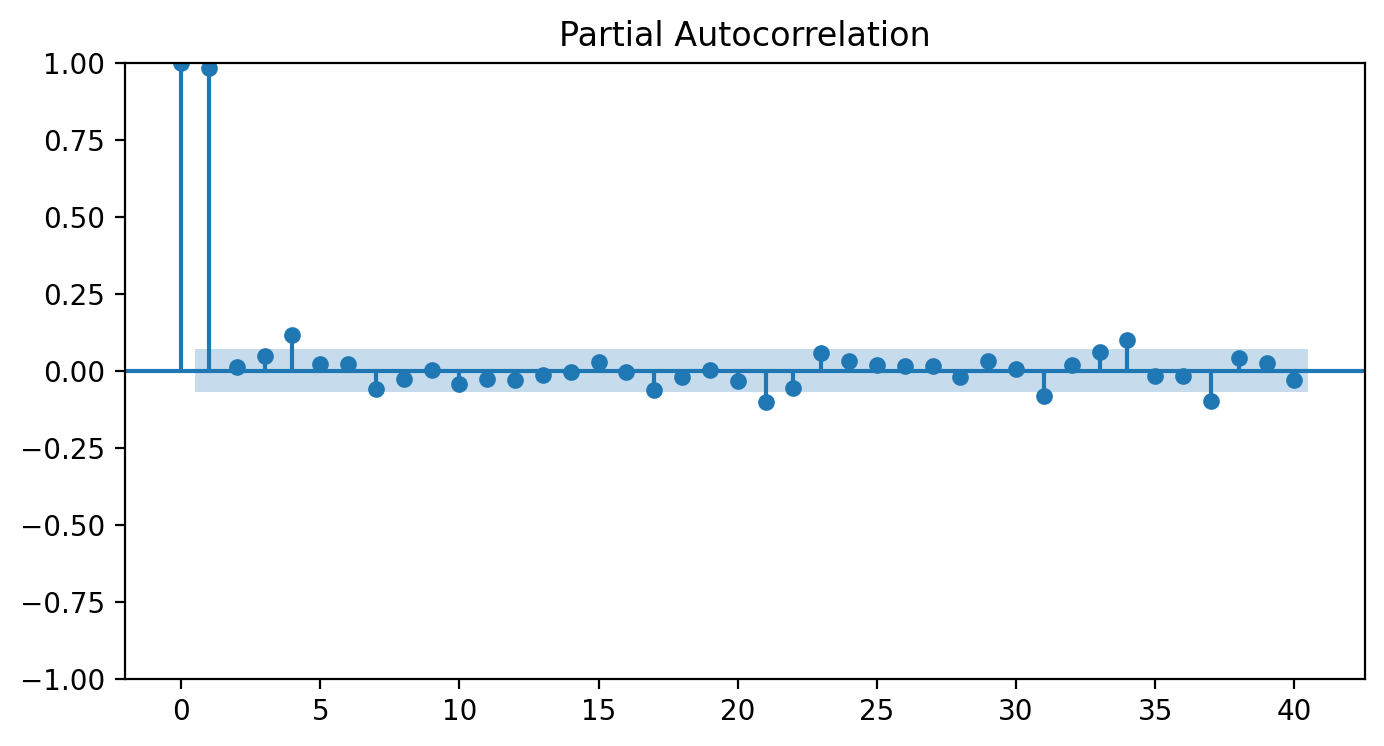

In [63]:
# let's make an PACF plot
fig = plot_pacf(train, lags=40, method='ywm')


PACF measures the incremental benefit of adding another lag. For example, the PACF plot below suggests lag1 and lag2 are highly correlated with price at current hour, but if we are already using lag1 and lag2 in the regression, adding lag3 as another predictor will not do much because its partial autocorrelation is almost zero.

In [64]:
# let's train an autoregression(2)
model = AutoReg(train, lags=2)
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                 BTCETH   No. Observations:                  792
Model:                     AutoReg(2)   Log Likelihood                1567.796
Method:               Conditional MLE   S.D. of innovations              0.033
Date:                Thu, 08 Dec 2022   AIC                          -3127.592
Time:                        21:27:09   BIC                          -3108.903
Sample:                    11-01-2022   HQIC                         -3120.408
                         - 12-03-2022                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.003      2.418      0.016       0.001       0.011
BTCETH.L1      0.9728      0.036     27.263      0.000       0.903       1.043
BTCETH.L2      0.0113      0.036      0.318      0.751      -0.059       0.081
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0160           +0.0000j            1.0160            0.0000
AR.2          -86.9112           +0.0000j           86.9112            0.5000
-----------------------------------------------------------------------------
"""

Note the coefficient estimate of lag2 (`BTCETH.L2`) is not significant, implying 
it's better to drop it from the model.

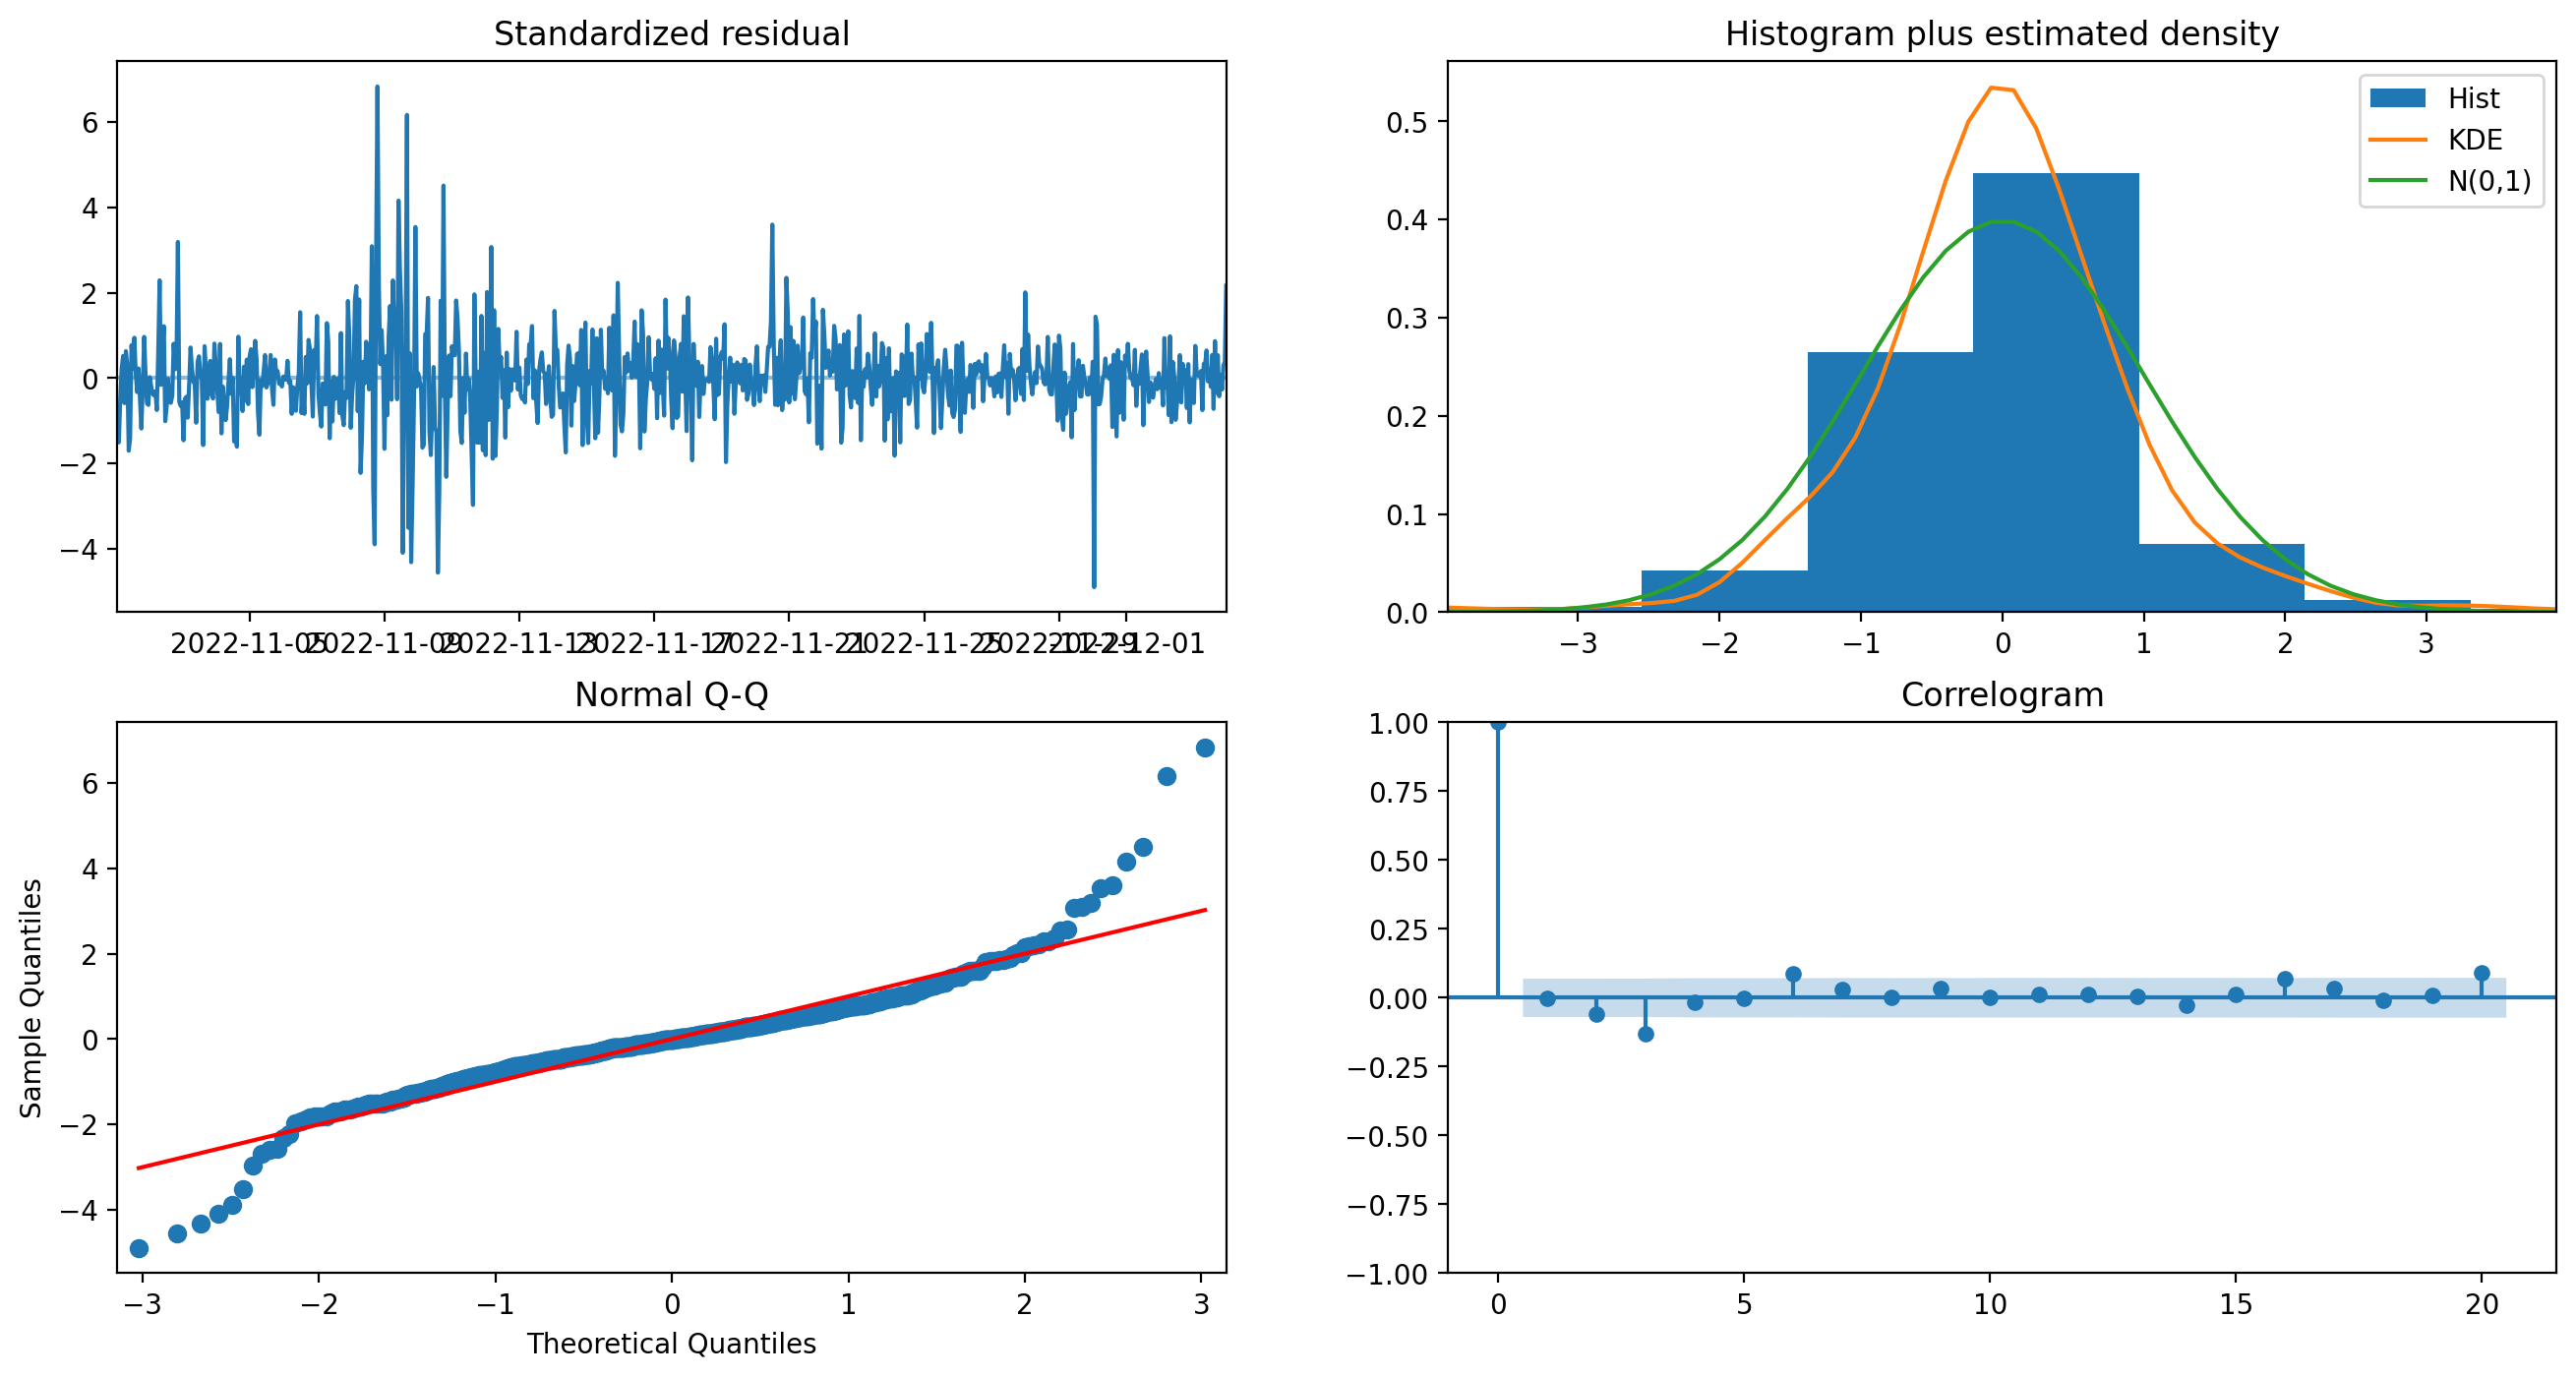

In [65]:
# let's plot the model diagnostics
# fig = model_fit.plot_diagnostics()
fig = plt.figure(figsize=(16, 8))
fig = model_fit.plot_diagnostics(fig=fig, lags=20)

In [66]:
# Or we can use ar_select_order() to pick the optimal number of lags automatically
sel = ar_select_order(train, maxlag=40)
print('Best lags to use in autoregression:', sel.ar_lags, end='\n\n')
model_fit = sel.model.fit()
print('Autoregression trained with best lags:')
print(model_fit.summary())

Best lags to use in autoregression: [1]

Autoregression trained with best lags:
                            AutoReg Model Results                             
Dep. Variable:                 BTCETH   No. Observations:                  792
Model:                     AutoReg(1)   Log Likelihood                1570.226
Method:               Conditional MLE   S.D. of innovations              0.033
Date:                Thu, 08 Dec 2022   AIC                          -3134.453
Time:                        21:27:16   BIC                          -3120.433
Sample:                    11-01-2022   HQIC                         -3129.064
                         - 12-03-2022                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0064      0.003      2.455      0.014       0.001       0.011
BTCETH.L1      0.9839      0.006    160.198      0.

We see the best lag selected by the algorithm is actually just `lag1`. This is 
consistent with what we saw before, that with lag1 present in the model, lag2 
isn't statistically significant.

#### Iterative training and forecasting

Now that we know the optimal order is 1. Let's train an AR(1) and make forecasts 
iteratively on a rolling 1-step basis. That is, as we iterate over the timestamps
in the test set, we will

1. train an AR(1) on the training set,
2. make a 1-step forecast, i.e., predict for the next hour,
3. update the training set by 
- dropping the first observation in the training set, and
- adding the test set observation at that timestamp to the end of the training set.

In [67]:
# how many records do you want to use for training every time you train? 
# set len(train) to use full training data. But we probably want to use a subset
# of more recent data since momentum breaks over a long period. Here I'm using 
# the previous 10 days, and each day has 24 hours. 
training_size = 10 * 24 

# extract training and test timeseries
ts_train = train.BTCETH[-training_size:]
ts_test = test.BTCETH

# change to list because we'll need to pop() and append() to training series
ts_train = list(ts_train)

In [68]:
# iterative AR(1) fitting and forecasting
predictions = list()
for t in range(len(ts_test)):
    model = AutoReg(ts_train, lags=1).fit()
    yhat = model.forecast(steps=1) # forecast() gives a 1d array of 1 element
    obs = ts_test[t]
    predictions.append(yhat)
    # update training timeseries by shifting the training window 1 step forward 
    ts_train.pop(0)
    ts_train.append(obs)

In [69]:
# reverse the scaling operation to get back at the original scale
predictions = scaler.inverse_transform(predictions)
actuals = scaler.inverse_transform(
    np.reshape(test.BTCETH.values, (len(test), 1)))

In [93]:
# put acutals and predictions side by side in the same data frame
df_pred = pd.DataFrame(
    np.concatenate([actuals, predictions], axis=1), 
    columns=['BTCETH_actual', 'BTCETH_forecast'], index=test.index)
# calc prediction error
df_pred['error'] = df_pred['BTCETH_actual'] - df_pred['BTCETH_forecast']
df_pred.head()

,BTCETH_actual,BTCETH_forecast,error
datetime,,,
2022-12-04 00:00:00,13.56,13.54,0.02
2022-12-04 01:00:00,13.51,13.55,-0.04
2022-12-04 02:00:00,13.48,13.51,-0.03
2022-12-04 03:00:00,13.44,13.48,-0.04
2022-12-04 04:00:00,13.43,13.44,-0.01


<AxesSubplot: xlabel='datetime'>

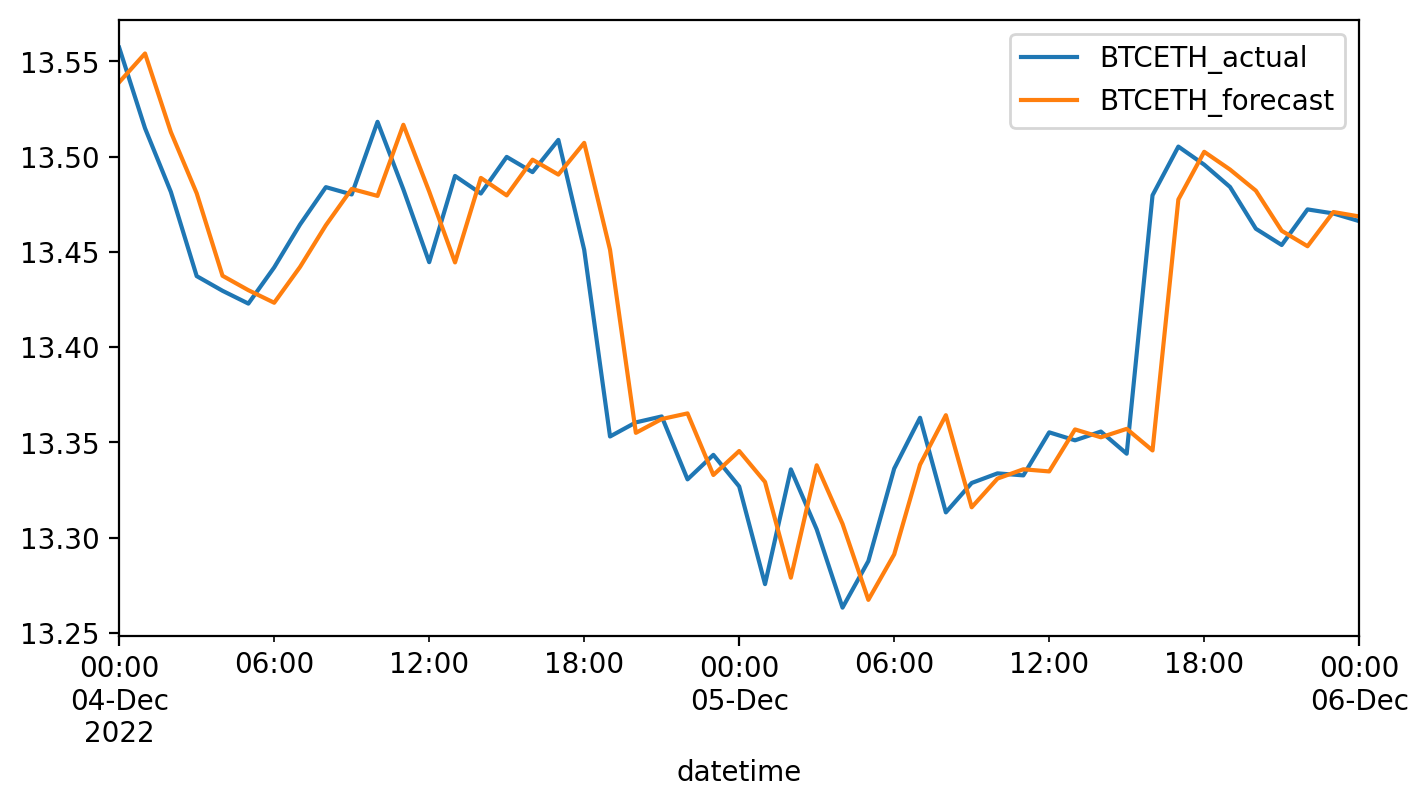

In [94]:
# plot forecast vs observations
df_pred[['BTCETH_actual', 'BTCETH_forecast']].plot()

<AxesSubplot: xlabel='datetime'>

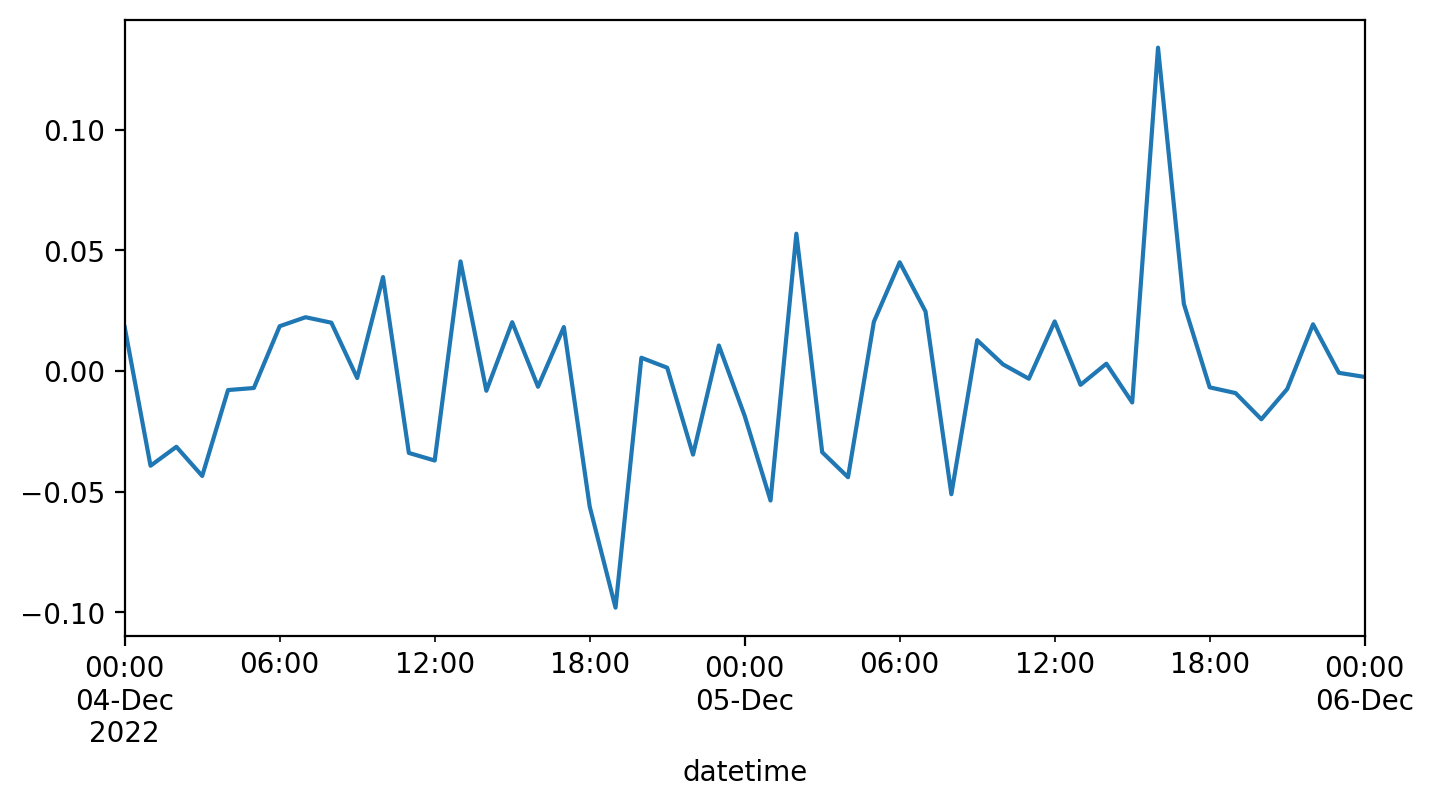

In [95]:
# calc and plot prediction error
df_pred['error'].plot()

In [96]:
def MAE(actuals, predictions):
    """Calculate mean absolute error"""
    return (abs(actuals - predictions)).mean()

def MAPE(actuals, predictions):
    """Calculate mean absolute percentage error"""
    return (abs(actuals - predictions) / actuals).mean()

In [97]:
print("1-step forecast MAE: ", MAE(df_pred.BTCETH_actual, df_pred.BTCETH_forecast), end='\n\n')
print("1-step forecast MAPE: ", MAPE(df_pred.BTCETH_actual, df_pred.BTCETH_forecast))

1-step forecast MAE:  0.025758686867116742

1-step forecast MAPE:  0.0019208982599098377
